# Heat Diffusion


We are going to be testing different methods of running heat diffusion simulations for efficiency. The general plot for plots will be as shown.

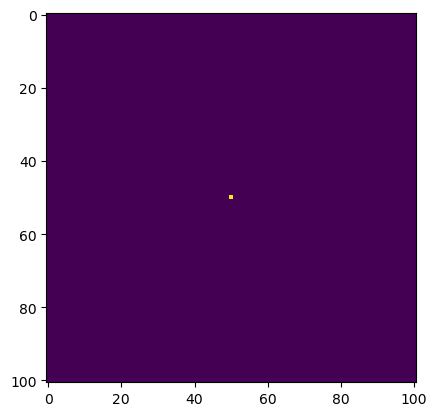

In [1]:
N = 101
epsilon = 0.2

import numpy as np
from matplotlib import pyplot as plt
# construct initial condition: 1 unit of heat at midpoint. 
u0 = np.zeros((N, N))
u0[int(N/2), int(N/2)] = 1.0
plt.imshow(u0)

The function we will be using for each of the 2700 iterations is:

u = u + epsilon * (A @ u.flatten()).reshape((N, N))



Lets create a starter matrix A with some diagonal non-zero enteries

In [3]:
A = np.zeros((N**2,N**2))

In [12]:
#add som diagonal non-zero enteries to A

for k in range (N**2):
    A[k,k] = -4
    
    if (k-1) >= 0:
        if k % N == 0:
            A[k,k-1] = 0
        else:
            A[k, k - 1] = 1
        
    if k + 1 <= N**2 - 1:
        if ( k + 1 ) % N == 0:
            A[k, k + 1] = 0
        else:
            A [k, k + 1] = 1
    
    if N + k <= N**2 - 1:
        A[k, N + k] = 1
        A[N + k, k] = 1
A

array([[-4.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -4.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -4., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -4.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -4.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -4.]])

   
 # Matrix multiplication
    
    
 Now we test our iteration algorithm using matrix multiplication
    

In [27]:
#provided initial value
sols=[]
u = u0

for i in range(1,2701):
    #provided update function
    u = u + epsilon * (A @ u.flatten()).reshape((N, N))

    if i % 300 == 0:
        sols.append(u)
            

In [15]:
%%time 

#provided initial value
sols=[]
u = u0

for i in range(1,2700):
    #provided update function
    u = u + epsilon * (A @ u.flatten()).reshape((N, N))

    if i % 300 == 0:
        sols.append(u)
            

CPU times: total: 6min 31s
Wall time: 1min 40s


This took an extremely long time, but we did get the correct results

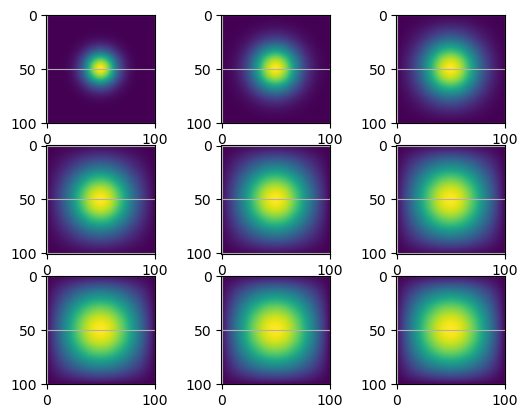

In [29]:
for i in range(9):
    
    plt.subplot(3,3,i + 1)
    plt.grid()
    plt.imshow(sols[i])



## Space 

Now lets try a different method. This one makes use of scipy's dia_matrix function. Lets see if it will make a difference

In [31]:
from scipy.sparse import dia_matrix

In [33]:
sparseMatrix = dia_matrix(A)

I choose to not make a function for this repeated operation to limit any possible external factor for runtime inconsistencies.

In [75]:
%%time 

#provided initial value
solsSparse=[]
u = u0

for i in range(1,2701):
    #provided update function
    u = u + epsilon * (sparseMatrix @ u.flatten()).reshape((N, N))

    if i % 300 == 0:
        solsSparse.append(u)
            

CPU times: total: 62.5 ms
Wall time: 64.1 ms


This is litterally a thousand times better

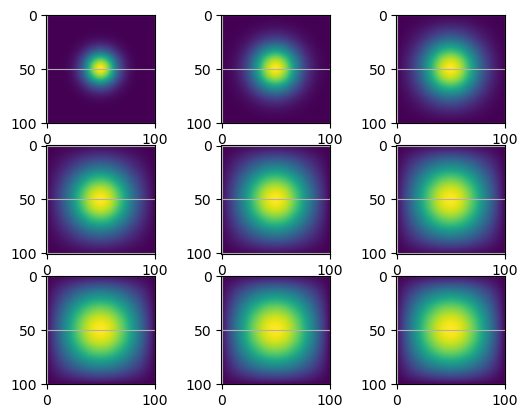

In [59]:
for i in range(9):
    
    plt.subplot(3,3,i + 1)
    plt.grid()
    plt.imshow(solsSparse[i])


## Numba

Now lets try another one. This one requires manual matrix multiplication to be used, and it will not work with any tools beyond the basics of python. Lets see if the runtime efficiency makes up for it

In [60]:
from numba import jit
import numpy as np

In [71]:

@jit(nopython=True)
def heat_equation_simulation(N, epsilon, iterations, interval):
    sols_numba = []
    u_current = u_initial  # Assuming u_initial is defined somewhere

    for k in range(1, iterations + 1):
        u_new = np.zeros((N, N))

        for i in range(N):
            for j in range(N):
                total_neighbor_heat = -4 * u_current[i, j]

                if i > 0:
                    total_neighbor_heat += u_current[i - 1, j]
                if i + 1 < N:
                    total_neighbor_heat += u_current[i + 1, j]
                if j > 0:
                    total_neighbor_heat += u_current[i, j - 1]
                if j + 1 < N:
                    total_neighbor_heat += u_current[i, j + 1]

                u_new[i, j] = u_current[i, j] + epsilon * total_neighbor_heat

        # Store solutions every so often for plotting
        if k % interval == 0:
            sols_numba.append(u_new)

        # Update u_current and repeat
        u_current = u_new

    return sols_numba


In [72]:
%%time
solsNumba = createMatrix()

CPU times: total: 31.2 ms
Wall time: 25.3 ms


About twice as fast as scipy. Pretty fast

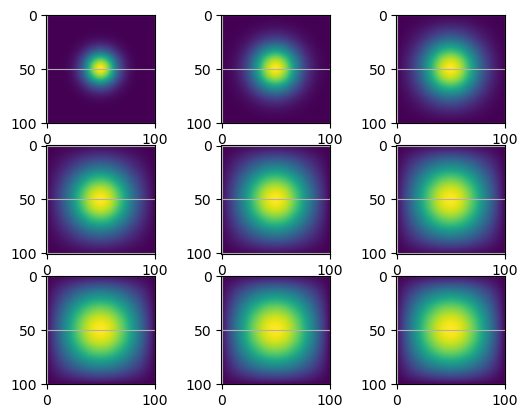

In [73]:
for i in range(9):
    
    plt.subplot(3,3,i + 1)
    plt.grid()
    plt.imshow(solsNumba[i])


# Comparison

Out of the 3 methods, the jit is by far the fastest. However, the scipy was easiest to write and is still very fast